# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 49 s, sys: 180 ms, total: 49.2 s
Wall time: 49.7 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,28
organization,25
article,42
codes,148
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [10]:
codingOrder = pd.DataFrame({'article': [
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-school-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    '2018-voter-registration',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [11]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,18,california-ccscore-analysis,"[format table display, read as tabular data, s...",0,23,"trim by quantitative threshold, peek at data, ..."
1,7,2019-04-democratic-candidate-codonors,"[use open government data, read as tabular dat...",1,43,compare different groups along a common metric...
2,19,california-crop-production-wages-analysis,"[use open government data, format table displa...",3,50,"adjust for inflation, answer a question, archi..."
3,21,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",4,52,"slice column values, tolerate dirty data"
4,31,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,63,"drop erroneous rows, scrape web for data, fill..."


Plot the size of the code set as more computational notebooks are analyzed.

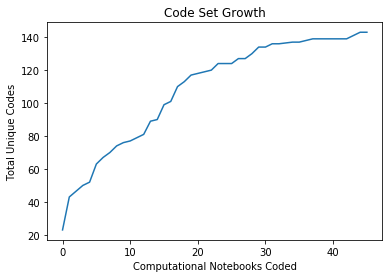

In [12]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [13]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: trim by quantitative threshold, peek at data, sort table, calculate z-score, create a crosstab, export results, drop duplicate rows based on values, subset columns, calculate difference, count value frequency, outer join tables, inspect table schema, trim by date range, calculate percentage difference, group by single column, format table display, split, compute, and merge, read as tabular data, count number of rows, change column data type, repetitive code, calculate mean, visualize data

2. **2019-04-democratic-candidate-codonors**: compare different groups along a common metric, calculate ratio, calculate scaled ratio, remove with regular expression, union tables, annotate workflow, architect a subroutine, self join table, change case, create a semi-unique key, sum along dimension, export intermediate results, group by multiple columns, use open government data, trim by contains value, canonicalize column names, strip whitespace, count unique values in column, drop duplicate rows based on prior knowledge, gather table

3. **california-crop-production-wages-analysis**: adjust for inflation, answer a question, architect repeating process, trim by geographic area, construct table manually, wrangle data for graphics, inner join tables

4. **census-hard-to-map-analysis**: slice column values, tolerate dirty data

5. **long-term-care-db**: drop erroneous rows, scrape web for data, fill in na values after an outer join, join with lookup table, perform entity resolution manually, construct pivot table, fix data errors manually, aggregate the forest from the trees, encode table identification in row, refine table, use non-public, provided data

6. **2018-voter-registration**: create rolling window, show trend over time, calculate a statistic, pull tables out of pdf

7. **heat_and_humidity**: generate data computationally, compute index number, cartesian product

8. **2016-11-bellwether-counties**: use academic data, get extreme values, remove incomplete data, spread table

9. **2018-05-31-crime-and-heat-analysis**: combine seemingly disparate datasets, extract property from datetime

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: wtf, use public data

12. **2016-04-republican-donor-movements**: explore dynamic network flow, split column on delimiter

13. **california-h2a-visas-analysis**: temporary joining column, split and compute, geocode addresses, create a unique key, cache results from external service, create child table, preserve existing values, replace na values

14. **Endangered-Species-Act-Louisiana**: transform vector

15. **Power_of_Irma**: value replacement, outlier detection, fix incorrect calculation, use data from colleague, use previously cleaned data, toggle step on and off, interpret statistical/ml model, set data confidence threshold, change date format

16. **wikipedia-rankings**: explain variance, collect raw data

17. **babyname_politics**: break ties, join aggregate, concatenate columns into key, get unique values, resort after merge, round floating point, assign ranks, data loss from aggregation, check results of previous operation

18. **2015-11-refugees-in-the-united-states**: designate column as primary key, make an incorrect conclusion, test for equality

19. **employment-discrimination**: merge tables to create pivot table, combine entities by string matching, concatenate files together, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: translate entity names manually, copy table schema, data too large for repo, create flag

24. **buster-posey-mvp**: 

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: sort table rows, report rows with column number discrepancies, correct bad formatting

27. **prison-admissions**: 

28. **school-star-ratings-2018**: reconcile primary keys between tables, display rows with missing values, pad column values

29. **electric-car-charging-points**: encode redundant information, find nearest neighbours in the network, create edge, define edge weights

30. **internal-migration-london**: 

31. **midwife-led-units**: freedom of information data, test different computations for equality

32. **librarians**: 

33. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices

34. **2018-voter-registration**: 

35. **2019-ems-analysis**: combine data and geography

36. **auditData**: combine columns

37. **lending-club**: 

38. **skatemusic**: 

39. **201901-hospitalquality**: 

40. **general-election-2015-classification-tree**: check for nas, wrangle data for model

41. **201901-achievementgap**: query database, bin values

42. **school-choice**: 